# Data Preparation

Load necessary libraries

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
import math
%matplotlib inline

Load the date fruit images and unzip files

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

# Location of Zip File
drive_path = '/gdrive/MyDrive/CIS 830 Machine learning/project/data3.zip'
local_path = '/content'

# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .

# Navigate to the copied file and unzip it quietly
os.chdir(local_path)
!unzip -q 'data3.zip'

Mounted at /gdrive


Divide the files under the unzipped folder into 80% (training) and 20% (testing) split using *splitfolders*.

In [ ]:
!pip install split-folders
import splitfolders

splitfolders.ratio("/content/data", output="output",
    seed=12345, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 9781 files [00:01, 7402.93 files/s]


Use *ImageDataGenerator* from Tensorflow’s Keras package to preprocess the images and load data into train and test generator.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create data generators
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    '/content/output/train',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='categorical',
                                                     seed=123)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    '/content/output/val',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='categorical',
                                                     seed=123,
                                                     shuffle=False)

Found 7823 images belonging to 5 classes.
Found 1958 images belonging to 5 classes.


Get a few useful data generator properties



In [ ]:
print('Number of classes: ', len(train_generator.class_indices))
print('Number of samples: train-{:d}, test-{:d}'.format(train_generator.samples, val_generator.samples))
print(train_generator.class_indices)

Number of classes:  5
Number of samples: train-7823, test-1958
{'meduim-ripe': 0, 'over-ripe': 1, 'ripe': 2, 'under-ripe': 3, 'unripe': 4}


In [ ]:
class_mapping = {v:k for k,v in train_generator.class_indices.items()}
print(class_mapping)

{0: 'meduim-ripe', 1: 'over-ripe', 2: 'ripe', 3: 'under-ripe', 4: 'unripe'}


In [ ]:
x,y = next(train_generator)
print('x: ',type(x))
print('y: ',type(y))
print('x: ',x.shape)
print('y: ',y.shape)

x:  <class 'numpy.ndarray'>
y:  <class 'numpy.ndarray'>
x:  (32, 224, 224, 3)
y:  (32, 5)


In [ ]:
#Get class int vale from one hot encoded labels
y_int = np.argmax(y,axis=-1)

**Visualizing data generator tensors**

Now we have a single batch and its lables with us, we will visualize and check whether everything is as expected. The grid plot utility function plots neat grids of images and helps in visualization. It accepts input **image_list** as either list of images or a numpy array. **nrows** and **ncols** are the rows and columns of the resultant grid respectively.

In [ ]:
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

An example visualization is shown below.

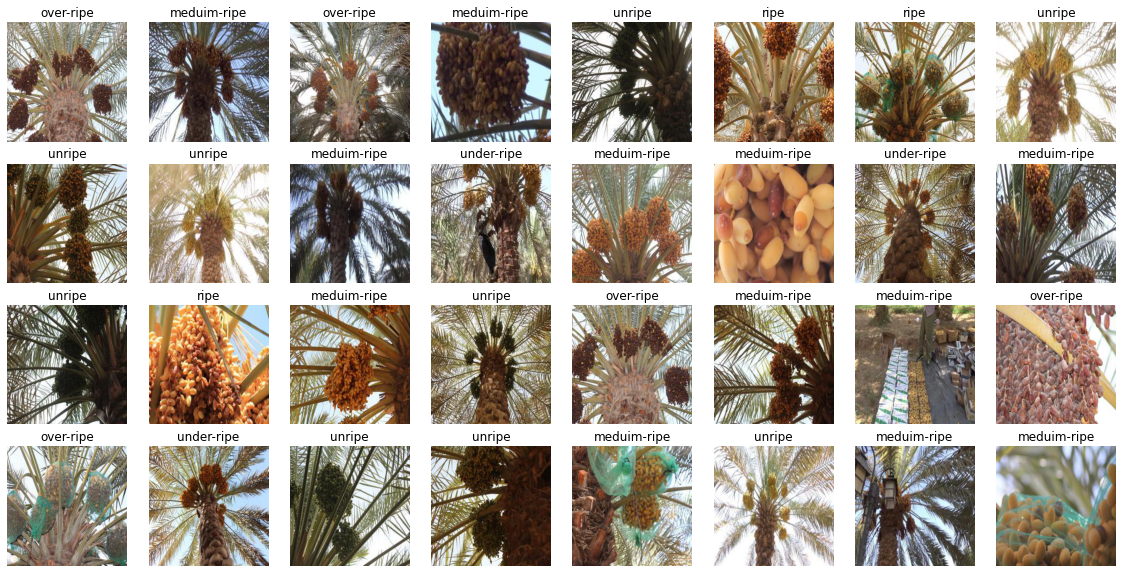

In [ ]:
show_grid(x,4,8,label_list=y_int,show_labels=True,figsize=(20,10))

# Baseline Model: a shallow CNN

Create a shallow convolution neural netwrok

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard


batch_size = 64
num_classes = 5
image_size = 224
lr = 0.0001      # learning rate


base_model = Sequential(name='baseline_model')
base_model.add(Conv2D(128, (3,3), padding='same', activation='relu',
                input_shape=(image_size, image_size, 3)))
base_model.add(MaxPooling2D(pool_size=(2,2)))
base_model.add(Dropout(0.15))
base_model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
base_model.add(MaxPooling2D(pool_size=(2,2)))
base_model.add(Dropout(0.15))
base_model.add(Flatten())   
base_model.add(Dense(32, activation='relu'))
base_model.add(Dropout(0.15))            
base_model.add(Dense(num_classes, activation='softmax'))

Visualize the layers created in the above step by using the summary function. 

In [ ]:
base_model.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)     

Compile the baseline model

In [ ]:
base_model.compile(Adam(lr), loss='CategoricalCrossentropy', metrics=['accuracy'])

Train the baseline model

In [ ]:
cb = TensorBoard()
base_history = base_model.fit(train_generator,
                              batch_size = batch_size,
                              epochs=40,
                              validation_data=val_generator,
                              callbacks=[cb])

Epoch 1/40
245/245 [==============================] - 51s 147ms/step - loss: 1.5381 - accuracy: 0.3458 - val_loss: 1.4888 - val_accuracy: 0.4157
Epoch 2/40
245/245 [==============================] - 36s 145ms/step - loss: 1.3613 - accuracy: 0.4368 - val_loss: 1.2778 - val_accuracy: 0.4857
Epoch 3/40
245/245 [==============================] - 35s 143ms/step - loss: 1.2178 - accuracy: 0.4974 - val_loss: 1.1445 - val_accuracy: 0.5567
Epoch 4/40
245/245 [==============================] - 35s 143ms/step - loss: 1.1295 - accuracy: 0.5334 - val_loss: 1.0749 - val_accuracy: 0.5664
Epoch 5/40
245/245 [==============================] - 35s 144ms/step - loss: 1.0803 - accuracy: 0.5552 - val_loss: 1.0939 - val_accuracy: 0.5746
Epoch 6/40
245/245 [==============================] - 35s 145ms/step - loss: 1.0201 - accuracy: 0.5861 - val_loss: 0.9784 - val_accuracy: 0.6410
Epoch 7/40
245/245 [==============================] - 35s 145ms/step - loss: 0.9716 - accuracy: 0.6151 - val_loss: 0.9680 - val_ac

Show the training losses and accuracy

Text(0.5, 0, 'epoch')

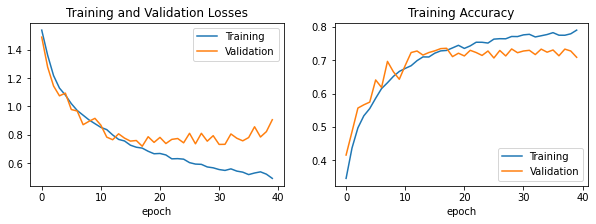

In [ ]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
plt.plot(base_history.history['loss'])
plt.plot(base_history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Losses')
plt.xlabel('epoch')

plt.subplot(122)
plt.plot(base_history.history['accuracy'])
plt.plot(base_history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training Accuracy')
plt.xlabel('epoch')

Model Evaluation on the Test Set

In [ ]:
test_loss, test_acc = base_model.evaluate(val_generator)
print('Test loss: {} Test Acc: {}'.format(test_loss, test_acc))

62/62 [==============================] - 4s 67ms/step - loss: 0.9065 - accuracy: 0.7089
Test loss: 0.9064935445785522 Test Acc: 0.7088866233825684


# ResNet50

Import the pre-trained ResNet50 model from *keras applications*.

While importing the **ResNet50 class**, we mention *include_top=False*. This ensures that we can add our own custom input and output layers according to our data.

We mention the *weights='imagenet'*. This means that the Resnet50 model will use the weights it learnt while being trained on the imagenet data.

Finally, we mention *layer.trainable= False* in the pretrained model. This ensures that the model does not learn the weights again.

In [ ]:
resnet_model = Sequential(name='resnet_model')

pretrained_model= tf.keras.applications.ResNet50V2(include_top=False,
                   input_shape=(image_size,image_size,3),
                   pooling='avg',classes=5,
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

94683136/94668760 [==============================] - 2s 0us/step


Change the output layer. In the output layer we use the softmax activation function and we have 5 output neurons corresponding to the 5 classes in our data.

In [ ]:
resnet_model.add(Flatten())
resnet_model.add(Dense(16, activation='relu'))
resnet_model.add(Dropout(0.15)) 
resnet_model.add(Dense(5, activation='softmax'))

Model architecture

In [ ]:
resnet_model.summary()

Model: "resnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 16)                32784     
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 23,597,669
Trainable params: 32,869
Non-trainable params: 23,564,800
_________________________________________________________________


Compile and run the model

In [ ]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(train_generator, validation_data = val_generator, epochs=40)

Epoch 1/40
245/245 [==============================] - 33s 121ms/step - loss: 1.0215 - accuracy: 0.6053 - val_loss: 0.7047 - val_accuracy: 0.7385
Epoch 2/40
245/245 [==============================] - 28s 113ms/step - loss: 0.6771 - accuracy: 0.7426 - val_loss: 0.5761 - val_accuracy: 0.7952
Epoch 3/40
245/245 [==============================] - 28s 112ms/step - loss: 0.5634 - accuracy: 0.7854 - val_loss: 0.4968 - val_accuracy: 0.8100
Epoch 4/40
245/245 [==============================] - 28s 113ms/step - loss: 0.4762 - accuracy: 0.8222 - val_loss: 0.4664 - val_accuracy: 0.8304
Epoch 5/40
245/245 [==============================] - 28s 113ms/step - loss: 0.4249 - accuracy: 0.8446 - val_loss: 0.4395 - val_accuracy: 0.8350
Epoch 6/40
245/245 [==============================] - 28s 113ms/step - loss: 0.3979 - accuracy: 0.8516 - val_loss: 0.4276 - val_accuracy: 0.8412
Epoch 7/40
245/245 [==============================] - 28s 113ms/step - loss: 0.3561 - accuracy: 0.8711 - val_loss: 0.4106 - val_ac

Show the training losses and accuracy

62/62 [==============================] - 6s 90ms/step - loss: 0.5441 - accuracy: 0.8641
Resnet model - Test loss: 0.5441436171531677 Test Acc: 0.8641470670700073


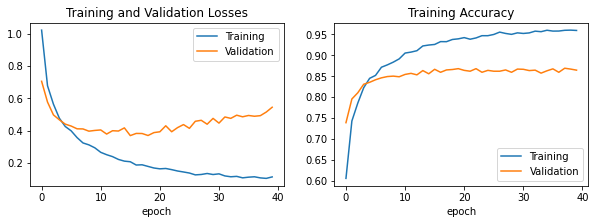

In [ ]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Losses')
plt.xlabel('epoch')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training Accuracy')
plt.xlabel('epoch')

test_loss, test_acc = resnet_model.evaluate(val_generator)
print('Resnet model - Test loss: {} Test Acc: {}'.format(test_loss, test_acc))

# Inceptionv3

In [ ]:
pre_incept = tf.keras.applications.InceptionV3(
    input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')


for layer in pre_incept.layers:
        layer.trainable=False

inc_model = Sequential(name="Inception_model")
inc_model.add(pre_incept)
inc_model.add(Flatten())
inc_model.add(Dense(5, activation='softmax'))

inc_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "Inception_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_4 (Dense)             (None, 5)                 256005    
                                                                 
Total params: 22,058,789
Trainable params: 256,005
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
inc_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
inc_history = inc_model.fit(train_generator,validation_data = val_generator,epochs = 40)

Epoch 1/40
245/245 [==============================] - 32s 112ms/step - loss: 1.0043 - accuracy: 0.6362 - val_loss: 0.6867 - val_accuracy: 0.7477
Epoch 2/40
245/245 [==============================] - 25s 100ms/step - loss: 0.4762 - accuracy: 0.8291 - val_loss: 0.6954 - val_accuracy: 0.7559
Epoch 3/40
245/245 [==============================] - 24s 99ms/step - loss: 0.3147 - accuracy: 0.8903 - val_loss: 0.6414 - val_accuracy: 0.7783
Epoch 4/40
245/245 [==============================] - 24s 99ms/step - loss: 0.2092 - accuracy: 0.9416 - val_loss: 0.5350 - val_accuracy: 0.8095
Epoch 5/40
245/245 [==============================] - 24s 99ms/step - loss: 0.1464 - accuracy: 0.9664 - val_loss: 0.5145 - val_accuracy: 0.8238
Epoch 6/40
245/245 [==============================] - 24s 98ms/step - loss: 0.1145 - accuracy: 0.9788 - val_loss: 0.4982 - val_accuracy: 0.8315
Epoch 7/40
245/245 [==============================] - 24s 98ms/step - loss: 0.0824 - accuracy: 0.9893 - val_loss: 0.5044 - val_accurac

62/62 [==============================] - 5s 79ms/step - loss: 0.6564 - accuracy: 0.8524
Efficient model - Test loss: 0.6563511490821838 Test Acc: 0.8524004220962524


Text(0.5, 0, 'epoch')

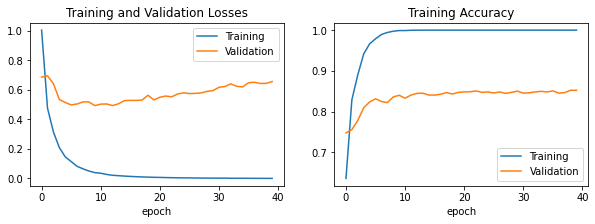

In [ ]:
test_loss, test_acc = inc_model.evaluate(val_generator)
print('Efficient model - Test loss: {} Test Acc: {}'.format(test_loss, test_acc))

fig = plt.figure(figsize=(10,3))

plt.subplot(121)
plt.plot(inc_history.history['loss'])
plt.plot(inc_history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Losses')
plt.xlabel('epoch')

plt.subplot(122)
plt.plot(inc_history.history['accuracy'])
plt.plot(inc_history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training Accuracy')
plt.xlabel('epoch')

# Model Evluation

**Define some useful functions for model evaulation**

Calcualte andd show confusion matrix for each model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def cm_cr(test_gen, model):
  predictions = model.predict(test_gen, verbose=0)
  y_pred = np.argmax(predictions, axis=-1)
  y_true=test_gen.classes
   # Get Class Labels
  class_names =list(test_gen.class_indices.keys())
  
  
  cm = confusion_matrix(y_true, y_pred)
  clr = classification_report(y_true, y_pred,digits=4)
  print("Classification Report:\n----------------------\n", clr)
  
  
  # Plot confusion matrix in a beautiful manner
  fig = plt.figure(figsize=(7, 5))
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
  # labels, title and ticks
  ax.set_xlabel('Predicted', fontsize=20)
  ax.xaxis.set_label_position('bottom')
  plt.xticks(rotation=90)
  ax.xaxis.set_ticklabels(class_names, fontsize = 10)
  ax.xaxis.tick_bottom()
  
  ax.set_ylabel('True', fontsize=20)
  ax.yaxis.set_ticklabels(class_names, fontsize = 10)
  plt.yticks(rotation=0)
  
  plt.title('Refined Confusion Matrix', fontsize=20)
  plt.show()

Plot ROC curves for the multi-class problem

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from scipy import stats, interp
from itertools import cycle

def multiple_roc(test_gen, model):

  n_classes = 5
  y = test_gen.classes
  enc = OneHotEncoder()
  y_test = enc.fit_transform(y[:, np.newaxis]).toarray()
  y_score = model.predict(test_gen)
  
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
    
  for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=(7, 6))
  plt.plot(fpr["micro"], tpr["micro"],
           label='micro-average ROC curve (area = {0:0.4f})'
                 ''.format(roc_auc["micro"]),
           color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
           label='macro-average ROC curve (area = {0:0.4f})'
                 ''.format(roc_auc["macro"]),
           color='navy', linestyle=':', linewidth=4)
    
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue',
                  'darkgreen','deeppink'])
    
  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
              label='ROC curve of class {0} (area = {1:0.4f})'
               ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

**Baseline model**

Confusion matrix and Classification Report 

Classification Report:
----------------------
               precision    recall  f1-score   support

           0     0.7373    0.8045    0.7695       670
           1     0.4983    0.6255    0.5547       235
           2     0.3333    0.0331    0.0602       242
           3     0.6359    0.6965    0.6648       346
           4     0.8563    0.9742    0.9115       465

    accuracy                         0.7089      1958
   macro avg     0.6122    0.6268    0.5921      1958
weighted avg     0.6691    0.7089    0.6713      1958



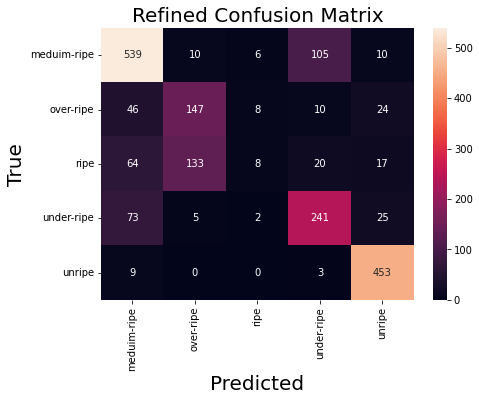

In [ ]:
cm_cr(val_generator, base_model)

ROC curve

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


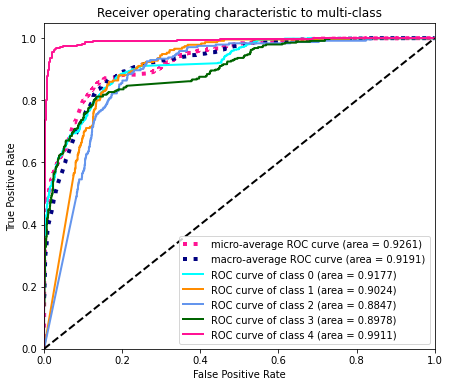

In [ ]:
multiple_roc(val_generator, base_model)

**Resnet50**

Confusion matrix and Classification Report

Classification Report:
----------------------
               precision    recall  f1-score   support

           0     0.8254    0.9030    0.8624       670
           1     0.8899    0.8596    0.8745       235
           2     0.8603    0.8140    0.8365       242
           3     0.8562    0.7572    0.8037       346
           4     0.9201    0.9161    0.9181       465

    accuracy                         0.8641      1958
   macro avg     0.8704    0.8500    0.8590      1958
weighted avg     0.8654    0.8641    0.8635      1958



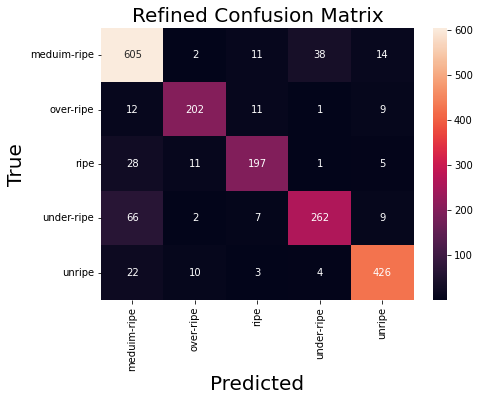

In [ ]:
cm_cr(val_generator, resnet_model)

ROC curve

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


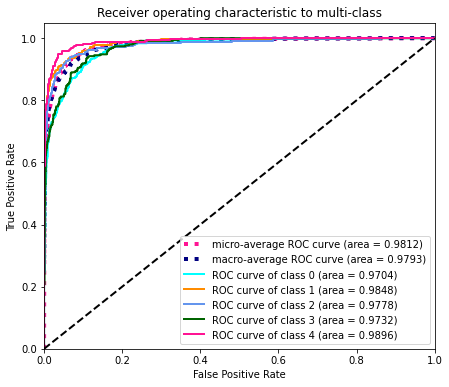

In [ ]:
multiple_roc(val_generator, resnet_model)

**Inceptionv3**

Confusion matrix and Classification Report

Classification Report:
----------------------
               precision    recall  f1-score   support

           0     0.8067    0.8657    0.8351       670
           1     0.9061    0.8213    0.8616       235
           2     0.8959    0.8182    0.8553       242
           3     0.8000    0.7746    0.7871       346
           4     0.9149    0.9247    0.9198       465

    accuracy                         0.8524      1958
   macro avg     0.8647    0.8409    0.8518      1958
weighted avg     0.8542    0.8524    0.8524      1958



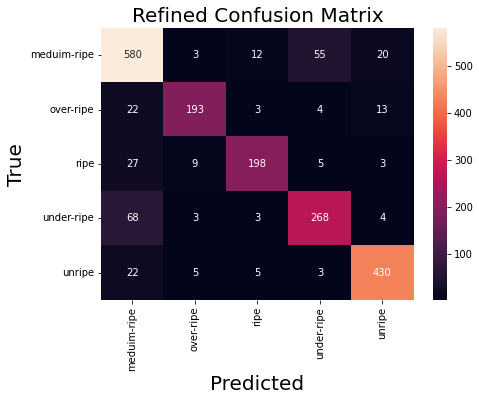

In [ ]:
cm_cr(val_generator, inc_model)

ROC curve

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


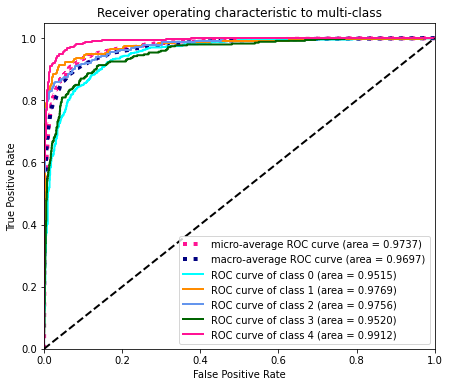

In [ ]:
multiple_roc(val_generator, inc_model)

**Compare micro-average ROC curves of different models**

In [ ]:
def roc(test_gen, models):
  
  y = test_gen.classes
  enc = OneHotEncoder()
  Y = enc.fit_transform(y[:, np.newaxis]).toarray()

  plt.figure(figsize=(7, 6))
  plt.plot([0, 1], [0, 1], 'k--')

  for model in models:
    yfit = model.predict(test_gen)
    fpr, tpr, _ = roc_curve(Y.ravel(),yfit.ravel())
    plt.plot(fpr, tpr, label='{}, AUC = {:.4f}'.format(model.name, auc(fpr, tpr)))

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend();

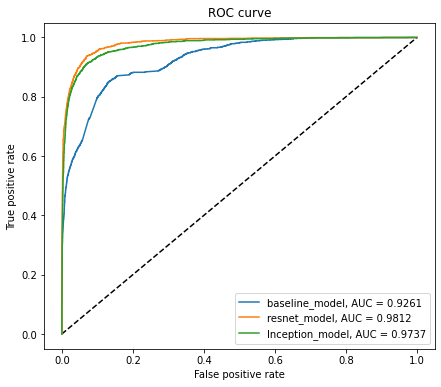

In [ ]:
models = []
models.append(base_model)
models.append(resnet_model)
models.append(inc_model)

roc(val_generator, models)

Visualize the architecture of baseline model

In [ ]:
! pip install git+https://github.com/paulgavrikov/visualkeras

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-21ofu3_x
  Running command git clone -q https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-21ofu3_x
     |████████████████████████████████| 992 kB 14.4 MB/s 
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13449 sha256=979348d79556c3481fce1c2c8b839577ee8349e33549ccbc75d87764abc360a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-cjy3_bxj/wheels/b8/3b/cf/30a062e766188d5fe50abf3d461720943b7d09906e3d261a94
Successfully built visualkeras


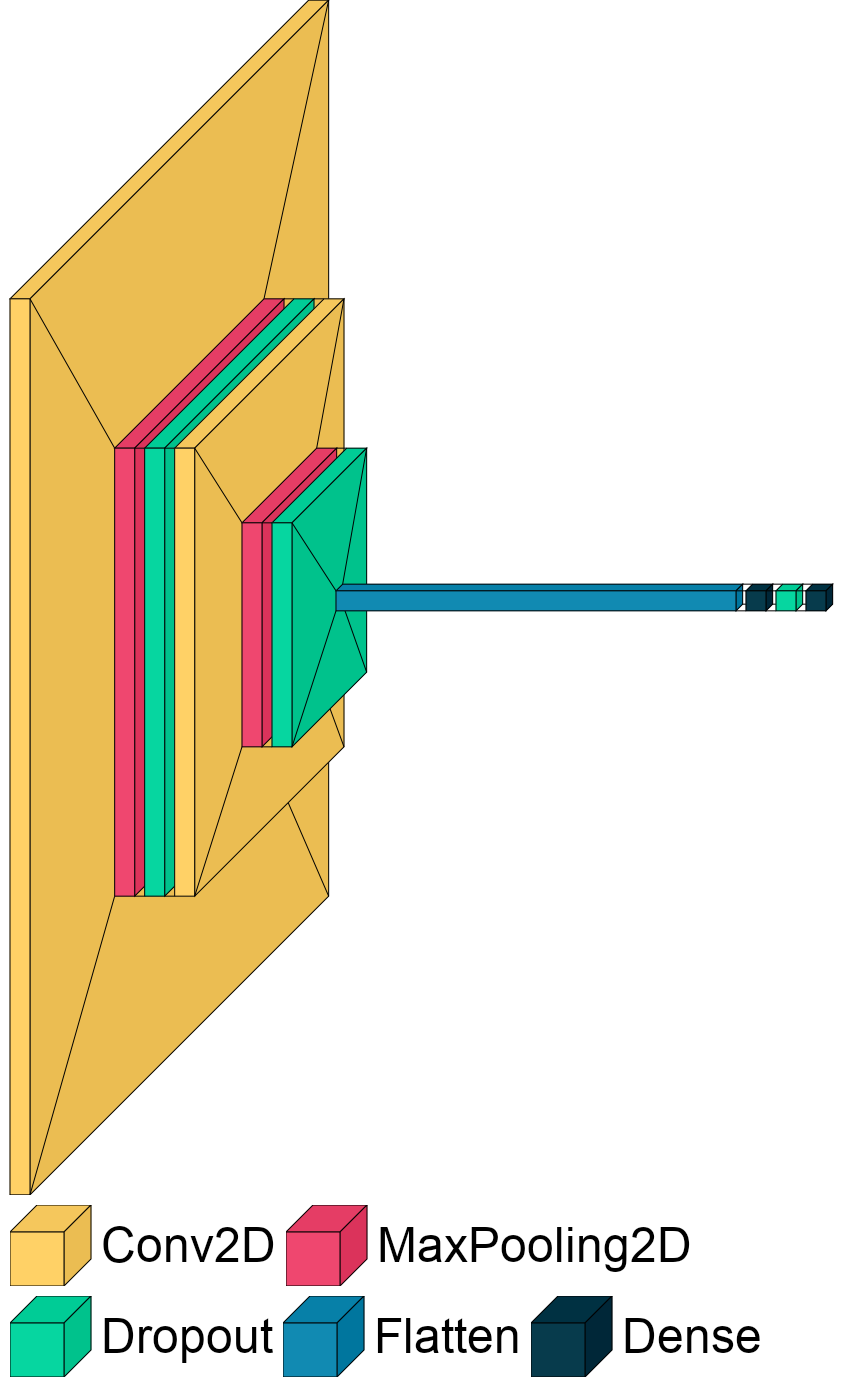

In [ ]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("/gdrive/MyDrive/CIS 830 Machine learning/project/Arial.ttf", 48)

visualkeras.layered_view(base_model, legend=True).show()
visualkeras.layered_view(base_model, legend=True, font = font, to_file='output.png')

Draw losses and accuracy during the training phase on the same plot

Text(0.5, 0, 'epoch')

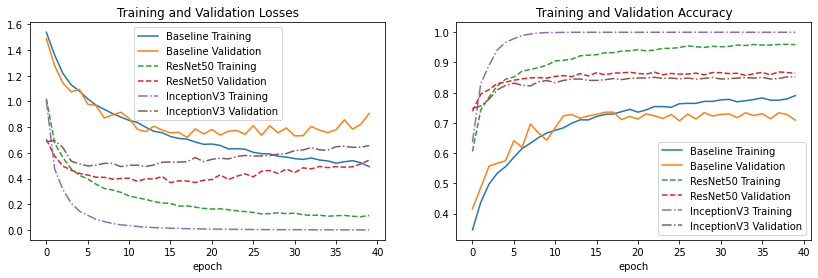

In [ ]:
fig = plt.figure(figsize=(14,4))

plt.subplot(121)
plt.plot(base_history.history['loss'],'-')
plt.plot(base_history.history['val_loss'],'-')
plt.plot(history.history['loss'],'--')
plt.plot(history.history['val_loss'],'--')
plt.plot(inc_history.history['loss'],'-.')
plt.plot(inc_history.history['val_loss'],'-.')
plt.legend(['Baseline Training', 'Baseline Validation',
            'ResNet50 Training', 'ResNet50 Validation',
            'InceptionV3 Training','InceptionV3 Validation'])
plt.title('Training and Validation Losses')
plt.xlabel('epoch')

plt.subplot(122)
plt.plot(base_history.history['accuracy'],'-')
plt.plot(base_history.history['val_accuracy'],'-')
plt.plot(history.history['accuracy'],'--')
plt.plot(history.history['val_accuracy'],'--')
plt.plot(inc_history.history['accuracy'],'-.')
plt.plot(inc_history.history['val_accuracy'],'-.')
plt.legend(['Baseline Training', 'Baseline Validation',
            'ResNet50 Training', 'ResNet50 Validation',
            'InceptionV3 Training','InceptionV3 Validation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')